In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing the Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


import math
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import linear_model

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from time import time
# models
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier 
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Reading the Dataset Files

In [ ]:
df_train=pd.read_csv("loan-train.csv")

In [ ]:
df_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### The main focus of this week's work is to performing boosting or stacking the best performing models in order to increase the accuracy beyond 82% (previous week's best)

In [ ]:
# to check the number of null values in each feature
df_train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

## Filling the Missing Values with Visualization

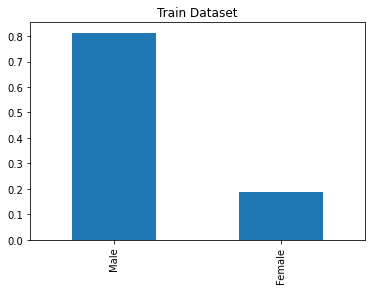

In [ ]:
ax1 = df_train['Gender'].value_counts(normalize=True).plot.bar(title='Train Dataset')
plt.show()

In [ ]:
# Since Majority of applicants are male, assigning the value male to missing values
df_train['Gender'] = df_train['Gender'].fillna("Male")

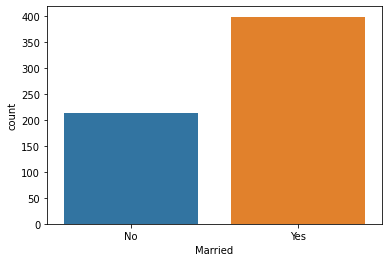

In [ ]:
sns.countplot(df_train['Married']);

In [ ]:
# Same thing with Married
df_train['Married'] = df_train['Married'].fillna("Yes")

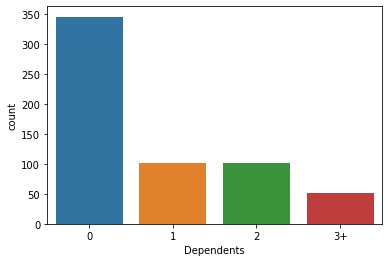

In [ ]:
sns.countplot(df_train['Dependents']);

In [ ]:
df_train['Dependents'] = df_train['Dependents'].fillna(0)

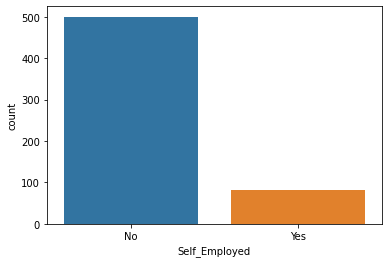

In [ ]:
sns.countplot(df_train['Self_Employed']);

In [ ]:
df_train['Self_Employed'] = df_train['Self_Employed'].fillna('No')

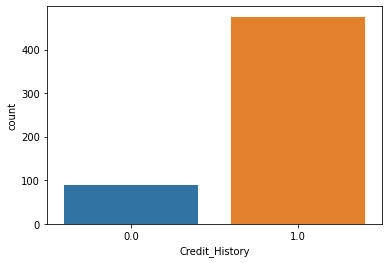

In [ ]:
sns.countplot(df_train['Credit_History']);

In [ ]:
df_train['Credit_History'] = df_train['Credit_History'].fillna(1.0)

In [ ]:
## Confirming whether all the null values are filled or not
df_train.isnull().sum()

Loan_ID               0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

In [ ]:
df_cat = df_train[['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed','Property_Area']]

df_cat_dummies = pd.get_dummies(df_cat)
df_train = pd.concat([df_train, df_cat_dummies], axis = 1)
df_train.drop(['Loan_ID','Gender', 'Married', 'Dependents', 'Education','Self_Employed','Property_Area'], axis = 1, inplace  =True)
df_train.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,5849,0.0,NaN,360.0,1.0,Y,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,1
1,4583,1508.0,128.0,360.0,1.0,N,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0
2,3000,0.0,66.0,360.0,1.0,Y,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,1
3,2583,2358.0,120.0,360.0,1.0,Y,0,1,0,1,0,1,0,0,0,0,1,1,0,0,0,1
4,6000,0.0,141.0,360.0,1.0,Y,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,1


#### The features LoanAmount and Loan_Amount_Term are numerical features, so we need to impute them using **Regression**

In [ ]:
df_train['Loan_Status'] = df_train['Loan_Status'].replace(['Y','N'],[1,0])

# Using Regression to impute missing data

In [ ]:
missing_columns = ["LoanAmount", "Loan_Amount_Term"]

The function random_imputation replaces the missing values with some random observed values of the variable. The method is repeated for all the variables containing missing values, after which they serve as parameters in the regression model to estimate other variable values.

Simple Random Imputation is one of the crude methods since it ignores all the other available data and thus it's very rarely used. But it serves as a good starting point for regression imputation.

In [ ]:
def random_imputation(df, feature):

    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    
    return df

In [ ]:
for feature in missing_columns:
    df_train[feature + '_imp'] = df_train[feature]
    df_train = random_imputation(df_train, feature)

# Deterministic Regression Imputation

In **Deterministic Regression Imputation**, we replace the missing data with the values predicted in our regression model and repeat this process for each variable.

In [ ]:
deter_data = pd.DataFrame(columns = ["Det" + name for name in missing_columns])

for feature in missing_columns:
        
    deter_data["Det" + feature] = df_train[feature + "_imp"]
    parameters = list(set(df_train.columns) - set(missing_columns) - {feature + '_imp'})
    
    #Create a Linear Regression model to estimate the missing data
    model = linear_model.LinearRegression()
    model.fit(X = df_train[parameters], y = df_train[feature + '_imp'])
    
    #observe that I preserve the index of the missing data from the original dataframe
    deter_data.loc[df_train[feature].isnull(), "Det" + feature] = model.predict(df_train[parameters])[df_train[feature].isnull()]

In [ ]:
df_train['LoanAmount']  = deter_data['DetLoanAmount']
df_train['Loan_Amount_Term']  = deter_data['DetLoan_Amount_Term']
df_train.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,LoanAmount_imp,Loan_Amount_Term_imp
0,5849,0.0,127.062641,360.0,1.0,1,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,1,128.0,360.0
1,4583,1508.0,128.000000,360.0,1.0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,128.0,360.0
2,3000,0.0,66.000000,360.0,1.0,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,1,66.0,360.0
3,2583,2358.0,120.000000,360.0,1.0,1,0,1,0,1,0,1,0,0,0,0,1,1,0,0,0,1,120.0,360.0
4,6000,0.0,141.000000,360.0,1.0,1,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,1,141.0,360.0


### Splitting the features and Target column for further Preprocessing Using PCA.

In [ ]:
X = df_train.drop(columns=['Loan_Amount_Term_imp','LoanAmount_imp','Loan_Status'], axis=1)
y = df_train['Loan_Status']

In [ ]:
## Getting the number of features that are there in the dataset, so that we can decide the number of components for PCA
X.shape

(614, 21)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components= 21)

X_pca = pca.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [ ]:
#Feature selection through Forward Step
sfs = SFS(XGBClassifier(n_estimators=100),
          k_features=8,
          verbose = 2,
          scoring='accuracy',
          cv=2,
          n_jobs=-1
         ).fit(X_train_scaled, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.5s finished

[2021-07-31 09:42:18] Features: 1/8 -- score: 0.8146424423427907[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished

[2021-07-31 09:42:18] Features: 2/8 -- score: 0.8146424423427907[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.6s finished

[2021-07-31 09:42:19] Features: 3/8 -- score: 0.8146424423427907[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.6s finished

[2021-07-31 09:42:19] Features: 4/8 -- score: 0.8146424423427907[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.6s finished

[202

## Therefore by the help of PCA and Feature Selection, we are able to achieve 82.073% accuracy